In [40]:
%pip install --quiet dibs-lib

In [41]:
"""
Ensemble Experiments for Causal Discovery with Interventional Data (Principled Approach)

This script compares SVGD and Deep Ensembles on their ability to recover
a causal graph when trained and evaluated on a mix of observational and
single-target interventional data.

This updated version includes a section for sampling from and plotting
interventional distributions from the ground truth and learned models.
"""

import jax
import jax.random as random
import jax.tree_util
import numpy as np
import time
import functools
import jax.numpy as jnp
import igraph as ig
import matplotlib.pyplot as plt
from jax import vmap, jit

from dibs.target import make_synthetic_bayes_net, make_graph_model
from dibs.models import DenseNonlinearGaussian
from dibs.inference import JointDiBS
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood


In [42]:
def create_interventional_data(key, n_vars, n_observations, n_ho_observations, n_intervention_sets, perc_intervened):
    """
    Generates synthetic data, combining observational and interventional for training,
    but keeping observational and interventional held-out sets separate.
    """
    print("\n" + "="*70)
    print("1. GENERATING GROUND TRUTH DATA")
    print("="*70)

    key, subk = random.split(key)

    # Define graph model and generative/likelihood models
    # The generative_model is used to create the ground truth data
    # The likelihood_model is used by DiBS for inference
    graph_model = make_graph_model(n_vars=n_vars, graph_prior_str="sf")
    generative_model = DenseNonlinearGaussian(
        n_vars=n_vars, hidden_layers=(5,), obs_noise=0.1, sig_param=1.0)
    likelihood_model = DenseNonlinearGaussian(
        n_vars=n_vars, hidden_layers=(5,), obs_noise=0.1, sig_param=1.0)

    # Generate all intervention sets and observational data
    data = make_synthetic_bayes_net(
        key=subk, n_vars=n_vars, graph_model=graph_model, generative_model=generative_model,
        n_observations=n_observations, n_ho_observations=n_ho_observations,
        n_intervention_sets=n_intervention_sets, perc_intervened=perc_intervened)

    # --- Create Combined Training Dataset ---
    # Start with observational data
    all_train_data = [data.x]
    all_train_masks = [jnp.zeros_like(data.x, dtype=bool)]

    # Add first (n_intervention_sets-1) interventional datasets for training
    for i in range(n_intervention_sets - 1):
        interv_dict, interv_x_train = data.x_interv[i]
        all_train_data.append(interv_x_train)

        # Create intervention mask
        mask_train_interv = jnp.zeros_like(interv_x_train, dtype=bool)
        intervened_nodes = list(interv_dict.keys())
        mask_train_interv = mask_train_interv.at[:, intervened_nodes].set(True)
        all_train_masks.append(mask_train_interv)

    # Finalize training set
    x_train = jnp.concatenate(all_train_data, axis=0)
    mask_train = jnp.concatenate(all_train_masks, axis=0)

    # --- Prepare Held-Out Sets ---
    # Observational held-out (already available)
    x_ho_obs = data.x_ho

    # Interventional held-out (use last intervention set)
    interv_dict_ho, x_ho_intrv = data.x_interv[-1]
    mask_ho_intrv = jnp.zeros_like(x_ho_intrv, dtype=bool)
    intervened_nodes_ho = list(interv_dict_ho.keys())
    mask_ho_intrv = mask_ho_intrv.at[:, intervened_nodes_ho].set(True)

    print(f"Ground truth graph generated.")
    print(f"\nTotal training samples: {x_train.shape[0]} (observational + {n_intervention_sets-1} interventional sets)")
    print(f"Held-out observational samples: {x_ho_obs.shape[0]}")
    print(f"Held-out interventional samples: {x_ho_intrv.shape[0]}")

    # Return the `data` object which contains ground truth graph and parameters
    return (x_train, mask_train, x_ho_obs, x_ho_intrv, mask_ho_intrv,
            data.g, graph_model, likelihood_model,generative_model, data )


In [43]:
def compute_metrics(dist, name, dibs_instance, x_ho, mask_ho, g_true):
    """Computes and prints metrics for a given particle distribution."""
    eshd = expected_shd(dist=dist, g=g_true)
    auroc = threshold_metrics(dist=dist, g=g_true)['roc_auc']

    # Compute negative average log-likelihood
    negll = neg_ave_log_likelihood(
        dist=dist,
        eltwise_log_likelihood=lambda g, theta: dibs_instance.likelihood_model.log_prob(g=g, theta=theta, x=x_ho, interv_mask=mask_ho),
        x=None
    )

    print(f'{name:25s} | E-SHD: {eshd:5.2f}  AUROC: {auroc:5.3f}  NegLL: {negll:7.2f}')
    return {'eshd': eshd, 'auroc': auroc, 'negll': negll}


# Parameters

In [44]:
N_PARTICLES = 20
N_ENSEMBLE_RUNS = 20
N_STEPS = 2000

key = random.PRNGKey(42)
print(f"JAX backend: {jax.default_backend()}")


JAX backend: gpu


# Generate Data

In [45]:
# 1. Generate Data
(x_train, mask_train, x_ho_obs, x_ho_intrv, mask_ho_intrv,
 g_true, graph_model, likelihood_model, generative_model, data) = create_interventional_data(
    key=key, n_vars=20, n_observations=100, n_ho_observations=100,
    n_intervention_sets=3, perc_intervened=0.1)



1. GENERATING GROUND TRUTH DATA
Ground truth graph generated.

Total training samples: 300 (observational + 2 interventional sets)
Held-out observational samples: 100
Held-out interventional samples: 100


# SVGD traning

In [46]:
print("\n" + "="*70)
print(f"3. SVGD BASELINE (1 run x {N_PARTICLES} particles)")
print("="*70)
key, subk = random.split(key)
dibs_svgd = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)

start_time = time.time()
gs_svgd, thetas_svgd = dibs_svgd.sample(key=subk, n_particles=N_PARTICLES, steps=N_STEPS)
svgd_time = time.time() - start_time

svgd_mixture = dibs_svgd.get_mixture(gs_svgd, thetas_svgd)
print(f"Finished in {svgd_time:.2f}s")



3. SVGD BASELINE (1 run x 20 particles)
Finished in 247.93s


# Deep ensemble training

In [47]:
print("\n" + "="*70)
print(f"4. DEEP ENSEMBLE ({N_ENSEMBLE_RUNS} runs x 1 particle)")
print("="*70)
ensemble_gs = []
ensemble_thetas = []

ensemble_start = time.time()
for i in range(N_ENSEMBLE_RUNS):
    print(f"Run {i+1}/{N_ENSEMBLE_RUNS}", end=" ")
    key, subk = random.split(key)
    dibs_single = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)
    gs, thetas = dibs_single.sample(key=subk, n_particles=1, steps=N_STEPS)

    ensemble_gs.append(gs)
    ensemble_thetas.append(thetas)
    print("✓")
ensemble_time = time.time() - ensemble_start

combined_gs = np.concatenate(ensemble_gs, axis=0)
combined_thetas = jax.tree_util.tree_map(lambda *arrays: np.concatenate(arrays, axis=0), *ensemble_thetas)

dibs_ensemble = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)
true_ensemble_mixture = dibs_ensemble.get_mixture(combined_gs, combined_thetas)
print(f"Finished in {ensemble_time:.2f}s")




4. DEEP ENSEMBLE (20 runs x 1 particle)
Run 1/20 ✓
Run 2/20 ✓
Run 3/20 ✓
Run 4/20 ✓
Run 5/20 ✓
Run 6/20 ✓
Run 7/20 ✓
Run 8/20 ✓
Run 9/20 ✓
Run 10/20 ✓
Run 11/20 ✓
Run 12/20 ✓
Run 13/20 ✓
Run 14/20 ✓
Run 15/20 ✓
Run 16/20 ✓
Run 17/20 ✓
Run 18/20 ✓
Run 19/20 ✓
Run 20/20 ✓
Finished in 344.90s


# Evaluation

In [48]:
print("\n" + "="*70)
print("5. EVALUATION")
print("="*70)

svgd_eshd = expected_shd(dist=svgd_mixture, g=g_true)
svgd_auroc = threshold_metrics(dist=svgd_mixture, g=g_true)['roc_auc']
ens_eshd = expected_shd(dist=true_ensemble_mixture, g=g_true)
ens_auroc = threshold_metrics(dist=true_ensemble_mixture, g=g_true)['roc_auc']

print("--- 5a. On OBSERVATIONAL Held-Out Data ---")
svgd_negll_obs = neg_ave_log_likelihood(
    dist=svgd_mixture,
    eltwise_log_likelihood=dibs_svgd.eltwise_log_likelihood_observ,
    x=x_ho_obs
)
ens_negll_obs = neg_ave_log_likelihood(
    dist=true_ensemble_mixture,
    eltwise_log_likelihood=dibs_ensemble.eltwise_log_likelihood_observ,
    x=x_ho_obs
)
print(f'SVGD Mixture (Obs)      | E-SHD: {svgd_eshd:5.2f}  AUROC: {svgd_auroc:5.3f}  NegLL: {svgd_negll_obs:7.2f}')
print(f'Ensemble Mixture (Obs)  | E-SHD: {ens_eshd:5.2f}  AUROC: {ens_auroc:5.3f}  NegLL: {ens_negll_obs:7.2f}')

print("\n--- 5b. On INTERVENTIONAL Held-Out Data ---")
svgd_negll_intrv = neg_ave_log_likelihood(
    dist=svgd_mixture,
    eltwise_log_likelihood=lambda g, theta, x: dibs_svgd.eltwise_log_likelihood_interv(g, theta, x, mask_ho_intrv),
    x=x_ho_intrv
)
ens_negll_intrv = neg_ave_log_likelihood(
    dist=true_ensemble_mixture,
    eltwise_log_likelihood=lambda g, theta, x: dibs_ensemble.eltwise_log_likelihood_interv(g, theta, x, mask_ho_intrv),
    x=x_ho_intrv
)
print(f'SVGD Mixture (Intrv)    | E-SHD: {svgd_eshd:5.2f}  AUROC: {svgd_auroc:5.3f}  NegLL: {svgd_negll_intrv:7.2f}')
print(f'Ensemble Mixture (Intrv)| E-SHD: {ens_eshd:5.2f}  AUROC: {ens_auroc:5.3f}  NegLL: {ens_negll_intrv:7.2f}')

# --- 6. Summary ---
print("\n" + "="*70)
print("6. SUMMARY")
print("="*70)
print(f"Computation time:")
print(f"  SVGD ({N_PARTICLES} particles):      {svgd_time:6.1f}s")
print(f"  Deep Ensemble ({N_ENSEMBLE_RUNS} × 1):   {ensemble_time:6.1f}s")
print("\n{:<25} | {:>10} | {:>10}".format("Metric", "SVGD", "Ensemble"))
print("-"*51)
print("{:<25} | {:10.2f} | {:10.2f}".format("E-SHD", svgd_eshd, ens_eshd))
print("{:<25} | {:10.3f} | {:10.3f}".format("AUROC", svgd_auroc, ens_auroc))
print("{:<25} | {:10.2f} | {:10.2f}".format("NLL (Observational)", svgd_negll_obs, ens_negll_obs))
print("{:<25} | {:10.2f} | {:10.2f}".format("NLL (Interventional)", svgd_negll_intrv, ens_negll_intrv))
print("="*70)




5. EVALUATION
--- 5a. On OBSERVATIONAL Held-Out Data ---
SVGD Mixture (Obs)      | E-SHD: 20.00  AUROC: 0.801  NegLL: 1621.05
Ensemble Mixture (Obs)  | E-SHD: 29.00  AUROC: 0.762  NegLL: 1793.16

--- 5b. On INTERVENTIONAL Held-Out Data ---
SVGD Mixture (Intrv)    | E-SHD: 20.00  AUROC: 0.801  NegLL: 1822.61
Ensemble Mixture (Intrv)| E-SHD: 29.00  AUROC: 0.762  NegLL: 2452.47

6. SUMMARY
Computation time:
  SVGD (20 particles):       247.9s
  Deep Ensemble (20 × 1):    344.9s

Metric                    |       SVGD |   Ensemble
---------------------------------------------------
E-SHD                     |      20.00 |      29.00
AUROC                     |      0.801 |      0.762
NLL (Observational)       |    1621.05 |    1793.16
NLL (Interventional)      |    1822.61 |    2452.47


In [49]:
print("\n" + "="*70)
print("7. SAVING RESULTS TO experiment_results.csv")
print("="*70)

results_path = "experiment_results.csv"
with open(results_path, "w") as f:
    f.write("Method,ESHD,AUROC,NLL_Observational,NLL_Interventional,Time_sec\n")
    f.write(f"SVGD,{svgd_eshd:.4f},{svgd_auroc:.4f},{svgd_negll_obs:.2f},{svgd_negll_intrv:.2f},{svgd_time:.2f}\n")
    f.write(f"Ensemble,{ens_eshd:.4f},{ens_auroc:.4f},{ens_negll_obs:.2f},{ens_negll_intrv:.2f},{ensemble_time:.2f}\n")
print(f"Results successfully saved to {results_path}")

# --- 8. Interventional Distribution Comparison ---
print("\n" + "="*70)
print("8. COMPARING INTERVENTIONAL DISTRIBUTIONS")
print("="*70)



7. SAVING RESULTS TO experiment_results.csv
Results successfully saved to experiment_results.csv

8. COMPARING INTERVENTIONAL DISTRIBUTIONS


# Interventional Distribution Comparison
Setting up. Find a strong link within the ground truth


Selected top 4 strongest edges:
  intervene on x_11, observe x_2 (strength 3.3868)
  intervene on x_4, observe x_2 (strength 2.1722)
  intervene on x_1, observe x_11 (strength 1.6909)
  intervene on x_12, observe x_11 (strength 1.5959)

Sampling p(X_2) (observational, no intervention) from ground truth.

Sampling p(X_2 | do(X_11 = 0.0)) from ground truth for the strongest link.


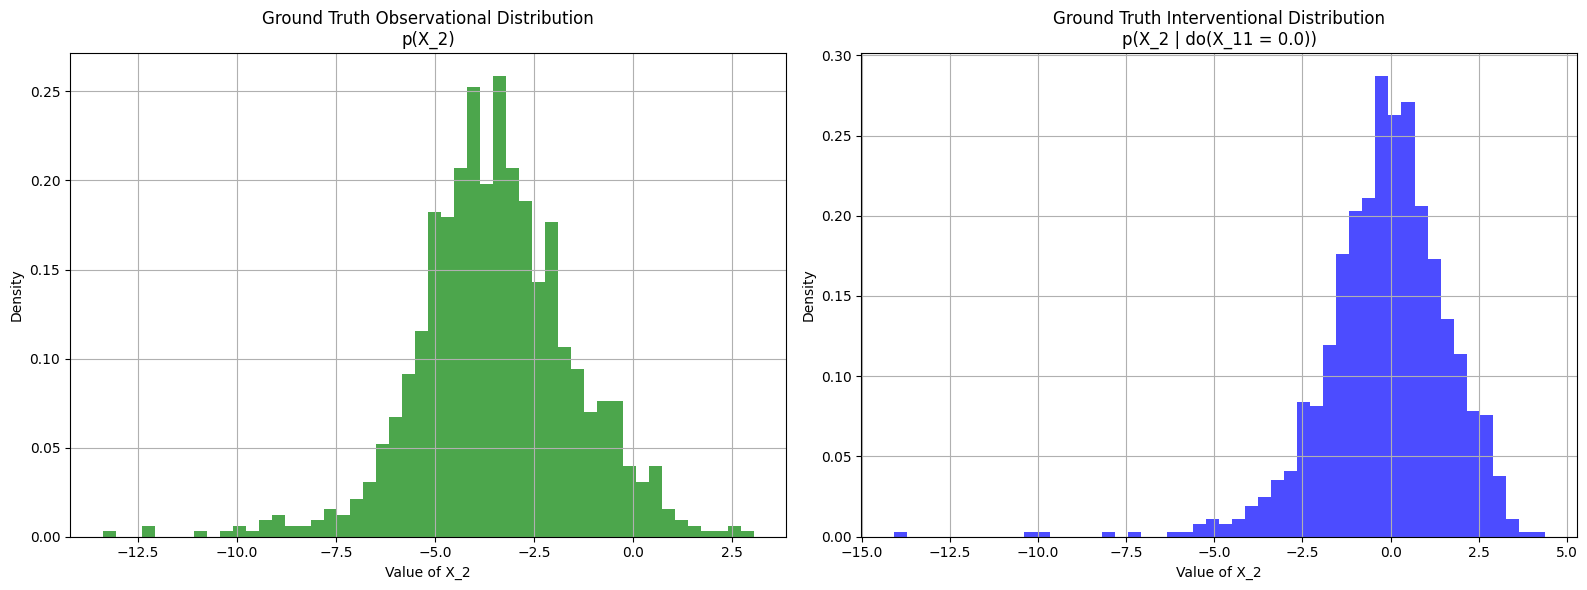

In [50]:
# Parameters for assessment and sampling
n_assess_samples = 1000  # Samples to assess effect strength
n_interv_samples = 1000  # Samples for final histogram
interv_value = 0.0
n_top_links = 4 # Number of top links to store

# Convert to numpy for easier manipulation
import numpy as np
g_true_np = np.array(data.g)
theta_np = data.theta  # PyTree, but we don't use it for weights

# Create igraph for sampling
g_true_igraph = ig.Graph.Adjacency(g_true_np.tolist())

# --- Part 1: Find strong links (using sampling to assess causal effect strength) ---
# Find all existing edges: (parent j, child i) where g_true[j, i] == 1
edges = np.argwhere(g_true_np == 1)  # shape [n_edges, 2], each [j, i]

# Measure causal effect strength by difference in mean of X_i with and without do(X_j=0)
effect_strengths = []

for j, i in edges:
    # Sample observational (no intervention)
    key, subk = random.split(key)
    obs_samples = generative_model.sample_obs(
        key=subk,
        n_samples=n_assess_samples,
        g=g_true_igraph,
        theta=theta_np,
        interv=None
    )
    obs_mean = np.mean(obs_samples[:, i])

    # Sample interventional do(X_j = interv_value)
    key, subk = random.split(key)
    interv_dict = {j: interv_value}
    interv_samples = generative_model.sample_obs(
        key=subk,
        n_samples=n_assess_samples,
        g=g_true_igraph,
        theta=theta_np,
        interv=interv_dict
    )
    interv_mean = np.mean(interv_samples[:, i])

    strength = abs(interv_mean - obs_mean)
    effect_strengths.append(strength)

# Select the top N strongest edges
if edges.size > 0:
    # Get indices that would sort the effect_strengths in descending order
    sorted_indices = np.argsort(effect_strengths)[::-1]
    # Select the top N indices
    top_n_indices = sorted_indices[:min(n_top_links, len(edges))]

    print(f"\nSelected top {len(top_n_indices)} strongest edges:")
    top_links = []
    for idx in top_n_indices:
        j, i = edges[idx]
        strength = effect_strengths[idx]
        top_links.append({'parent': j, 'child': i, 'strength': strength})
        print(f"  intervene on x_{j}, observe x_{i} (strength {strength:.4f})")

    # For now, we will still use the strongest edge for plotting later in this cell
    # The strongest edge is the first one in the top_links list
    strongest_link = top_links[0]
    j = strongest_link['parent']
    i = strongest_link['child']
    interv_dict = {j: interv_value} # Update interv_dict for plotting

else:
    raise ValueError("No edges in the graph!")

# --- Part 2: Sample observational and interventional distributions ---
# Observational sampling (no intervention)
print(f"\nSampling p(X_{i}) (observational, no intervention) from ground truth.")
key, subk = random.split(key)
gt_obs_samples = generative_model.sample_obs(
    key=subk,
    n_samples=n_interv_samples,
    g=g_true_igraph,
    theta=theta_np,
    interv=None
)

# Interventional sampling
print(f"\nSampling p(X_{i} | do(X_{j} = {interv_value})) from ground truth for the strongest link.")
key, subk = random.split(key)
gt_interv_samples = generative_model.sample_obs(
    key=subk,
    n_samples=n_interv_samples,
    g=g_true_igraph,
    theta=theta_np,
    interv=interv_dict
)

# Plot histograms for comparison (only for the strongest link currently)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.7, color='green')
axs[0].set_title(f"Ground Truth Observational Distribution\np(X_{i})")
axs[0].set_xlabel(f"Value of X_{i}")
axs[0].set_ylabel("Density")
axs[0].grid(True)

axs[1].hist(gt_interv_samples[:, i], bins=50, density=True, alpha=0.7, color='blue')
axs[1].set_title(f"Ground Truth Interventional Distribution\np(X_{i} | do(X_{j} = {interv_value}))")
axs[1].set_xlabel(f"Value of X_{i}")
axs[1].set_ylabel("Density")
axs[1].grid(True)

plt.tight_layout()
filename = f"results_gt_dist_X{i}_doX{j}_{interv_value}.jpg"
fig.savefig(filename, dpi=300, bbox_inches="tight")

plt.show()

# The 'top_links' variable now contains a list of dictionaries, each describing
# a top link (parent, child, strength). You can use this variable
# in subsequent cells to analyze or visualize these links.

# Evaluating interventional distributions learned models

Sampling interventional distributions properly...
All sampling successful! Plotting results...


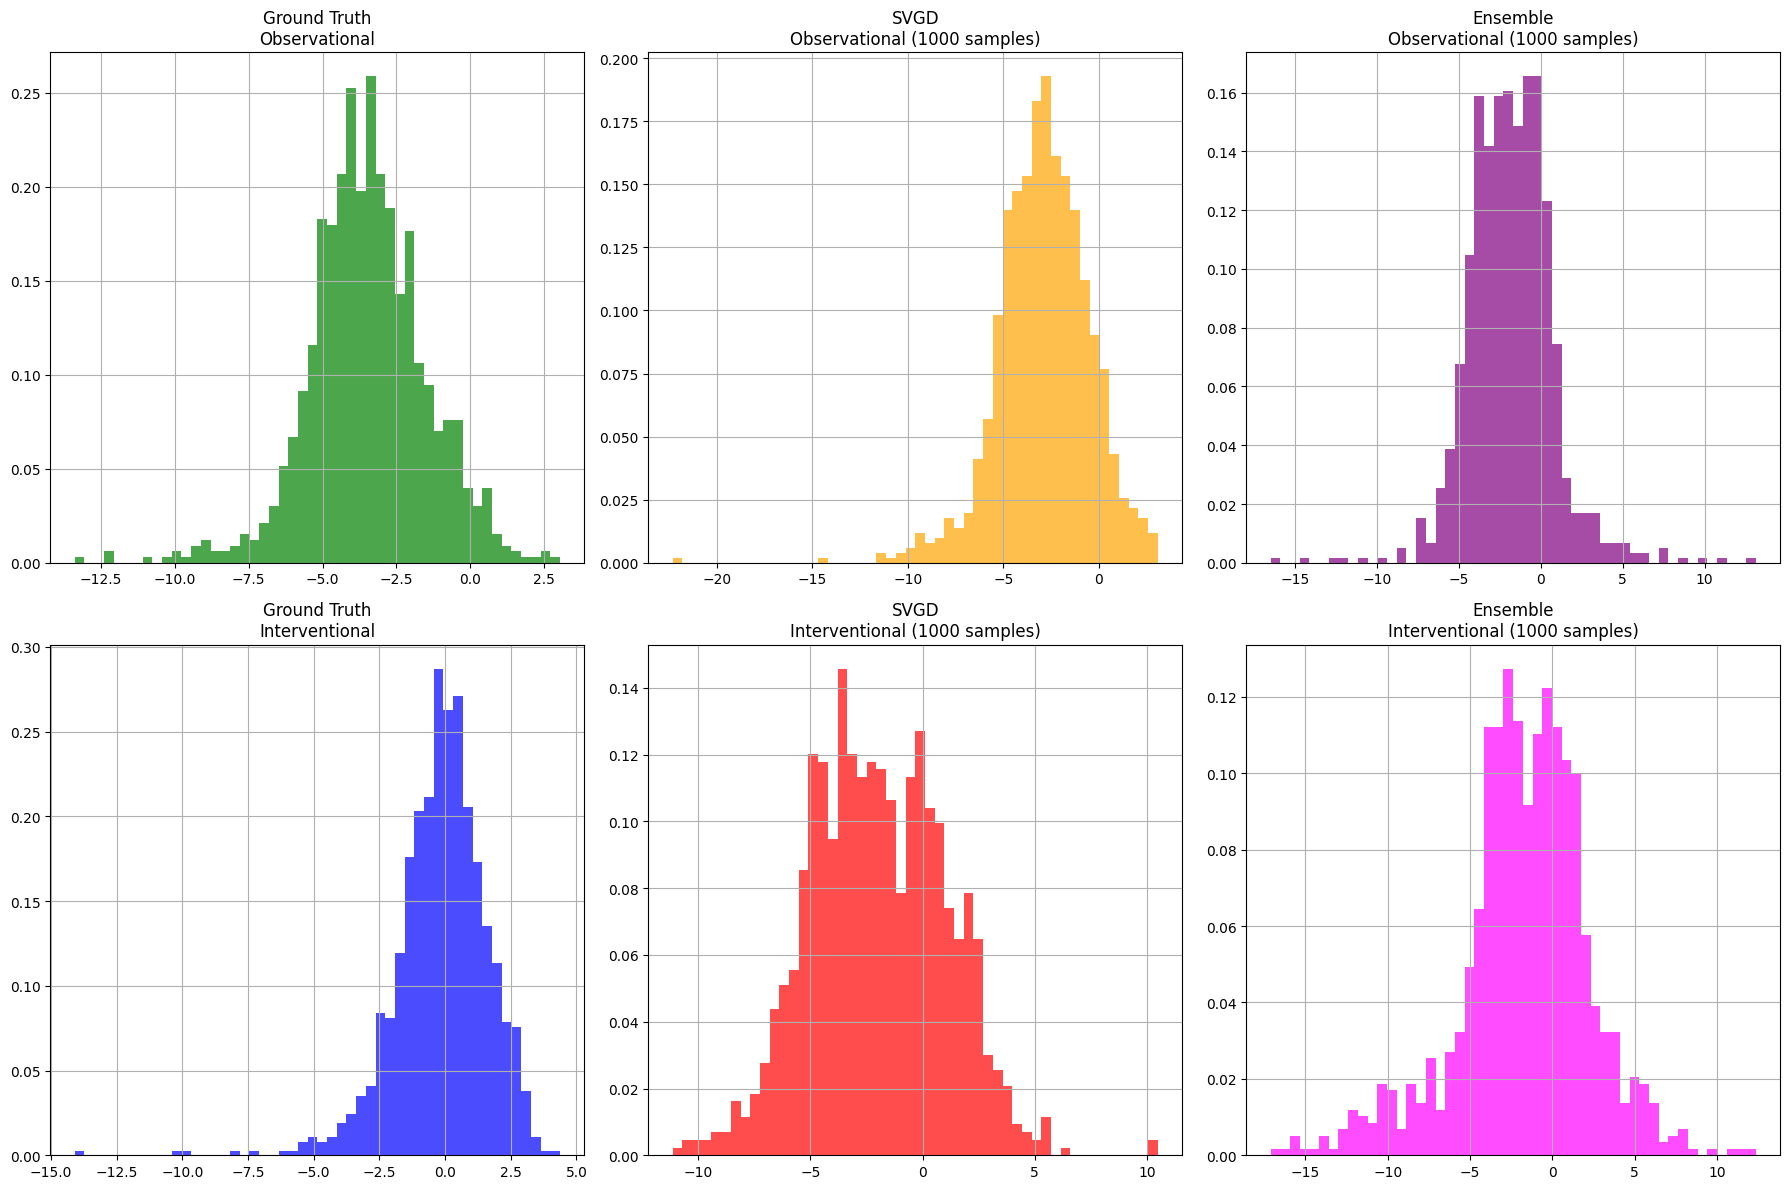

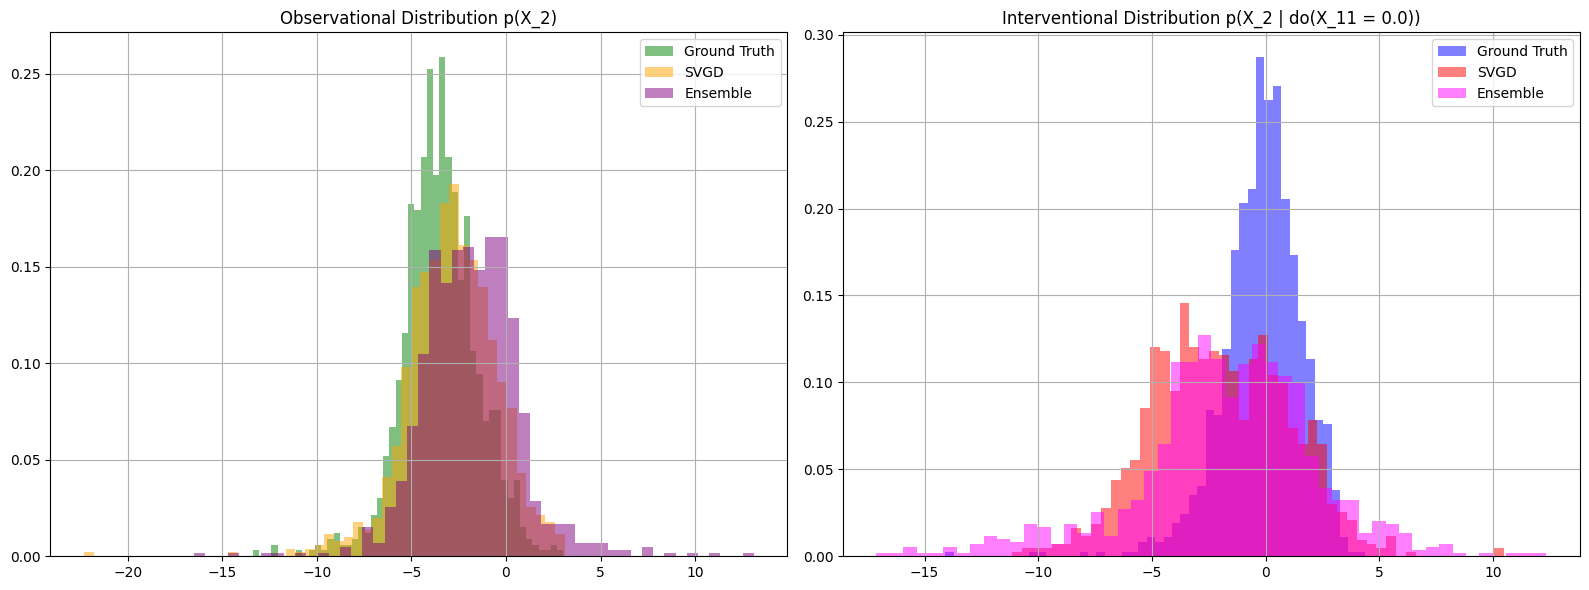

In [51]:
def sample_interventional_distribution_from_particles(gs, thetas, likelihood_model,
                                                     interv_dict, n_samples_per_particle,
                                                     obs_node, key):
    """
    Properly sample interventional distributions from DiBS particles.

    For each particle (g_i, theta_i), we:
    1. Convert g_i to igraph
    2. Sample from likelihood_model.sample_obs with intervention
    3. Aggregate samples across all particles

    This gives us samples from the posterior predictive distribution:
    p(X_obs | do(X_j = value), D) = ∫ p(X_obs | do(X_j = value), G, Θ) p(G, Θ | D) dG dΘ
    """

    all_samples = []
    n_particles = gs.shape[0]

    for p in range(n_particles):
        try:
            # Get this particle's graph and parameters
            g_matrix = np.array(gs[p])
            particle_theta = jax.tree_map(lambda x: x[p], thetas)

            # Convert to igraph
            g_igraph = ig.Graph.Adjacency(g_matrix.tolist())

            # Check if DAG (skip if not)
            if not g_igraph.is_dag():
                continue

            # Sample from this particle's model
            key, subk = random.split(key)
            samples = likelihood_model.sample_obs(
                key=subk,
                n_samples=n_samples_per_particle,
                g=g_igraph,
                theta=particle_theta,
                interv=interv_dict
            )

            # Extract the observed variable
            all_samples.append(samples[:, obs_node])

        except Exception as e:
            # Skip problematic particles
            continue

    if len(all_samples) == 0:
        return None

    # Combine all samples - this represents the posterior predictive
    return np.concatenate(all_samples)

# Now use this function properly for both SVGD and Ensemble
print("Sampling interventional distributions properly...")

# SVGD interventional
svgd_interv_samples = sample_interventional_distribution_from_particles(
    gs_svgd, thetas_svgd, likelihood_model, interv_dict,
    n_interv_samples // N_PARTICLES, i, key
)

# SVGD observational (no intervention)
svgd_obs_samples = sample_interventional_distribution_from_particles(
    gs_svgd, thetas_svgd, likelihood_model, None,  # No intervention
    n_interv_samples // N_PARTICLES, i, key
)

# Ensemble interventional
ensemble_interv_samples = sample_interventional_distribution_from_particles(
    combined_gs, combined_thetas, likelihood_model, interv_dict,
    n_interv_samples // N_ENSEMBLE_RUNS, i, key
)

# Ensemble observational
ensemble_obs_samples = sample_interventional_distribution_from_particles(
    combined_gs, combined_thetas, likelihood_model, None,
    n_interv_samples // N_ENSEMBLE_RUNS, i, key
)

# Check results and plot
if all(x is not None for x in [svgd_obs_samples, svgd_interv_samples,
                               ensemble_obs_samples, ensemble_interv_samples]):

    print("All sampling successful! Plotting results...")

    # Create plots
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Ground truth (for reference)
    axs[0, 0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.7, color='green')
    axs[0, 0].set_title("Ground Truth\nObservational")
    axs[0, 0].grid(True)

    axs[1, 0].hist(gt_interv_samples[:, i], bins=50, density=True, alpha=0.7, color='blue')
    axs[1, 0].set_title("Ground Truth\nInterventional")
    axs[1, 0].grid(True)

    # SVGD
    axs[0, 1].hist(svgd_obs_samples, bins=50, density=True, alpha=0.7, color='orange')
    axs[0, 1].set_title(f"SVGD\nObservational ({len(svgd_obs_samples)} samples)")
    axs[0, 1].grid(True)

    axs[1, 1].hist(svgd_interv_samples, bins=50, density=True, alpha=0.7, color='red')
    axs[1, 1].set_title(f"SVGD\nInterventional ({len(svgd_interv_samples)} samples)")
    axs[1, 1].grid(True)

    # Ensemble
    axs[0, 2].hist(ensemble_obs_samples, bins=50, density=True, alpha=0.7, color='purple')
    axs[0, 2].set_title(f"Ensemble\nObservational ({len(ensemble_obs_samples)} samples)")
    axs[0, 2].grid(True)

    axs[1, 2].hist(ensemble_interv_samples, bins=50, density=True, alpha=0.7, color='magenta')
    axs[1, 2].set_title(f"Ensemble\nInterventional ({len(ensemble_interv_samples)} samples)")
    axs[1, 2].grid(True)

    plt.tight_layout()
    filename = f"results_svgd_ensemble_interventional_dist_X{i}_doX{j}_{interv_value}.jpg"
    fig.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()

    # Comparison plots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Observational comparison
    axs[0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.5,
                label='Ground Truth', color='green')
    axs[0].hist(svgd_obs_samples, bins=50, density=True, alpha=0.5,
                label='SVGD', color='orange')
    axs[0].hist(ensemble_obs_samples, bins=50, density=True, alpha=0.5,
                label='Ensemble', color='purple')
    axs[0].set_title(f"Observational Distribution p(X_{i})")
    axs[0].legend()
    axs[0].grid(True)

    # Interventional comparison
    axs[1].hist(gt_interv_samples[:, i], bins=50, density=True, alpha=0.5,
                label='Ground Truth', color='blue')
    axs[1].hist(svgd_interv_samples, bins=50, density=True, alpha=0.5,
                label='SVGD', color='red')
    axs[1].hist(ensemble_interv_samples, bins=50, density=True, alpha=0.5,
                label='Ensemble', color='magenta')
    axs[1].set_title(f"Interventional Distribution p(X_{i} | do(X_{j} = {interv_value}))")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    filename = f"results_combined_interventional_dist_X{i}_doX{j}_{interv_value}.jpg"
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

else:
    print("Some sampling failed - likely due to insufficient training or no valid DAG particles")

Target node for observation selected: x_2 (last in topological order)
Found 19 candidate intervention nodes for target x_2.

Assessing causal effect strength for each candidate intervention...
  do(x_0=0.0) -> x_2: strength = 0.1997
  do(x_4=0.0) -> x_2: strength = 2.2643
  do(x_5=0.0) -> x_2: strength = 0.1828
  do(x_9=0.0) -> x_2: strength = 0.0109
  do(x_11=0.0) -> x_2: strength = 3.3299
  do(x_14=0.0) -> x_2: strength = 0.6270
  do(x_16=0.0) -> x_2: strength = 0.4724
  do(x_17=0.0) -> x_2: strength = 0.1887
  do(x_18=0.0) -> x_2: strength = 0.0596
  do(x_3=0.0) -> x_2: strength = 0.7883
  do(x_1=0.0) -> x_2: strength = 1.1901
  do(x_7=0.0) -> x_2: strength = 1.0286
  do(x_12=0.0) -> x_2: strength = 0.9176
  do(x_13=0.0) -> x_2: strength = 0.1000
  do(x_15=0.0) -> x_2: strength = 0.0474
  do(x_6=0.0) -> x_2: strength = 0.2774
  do(x_8=0.0) -> x_2: strength = 0.0772
  do(x_10=0.0) -> x_2: strength = 0.1745
  do(x_19=0.0) -> x_2: strength = 0.2451

Selected top 4 strongest causal link

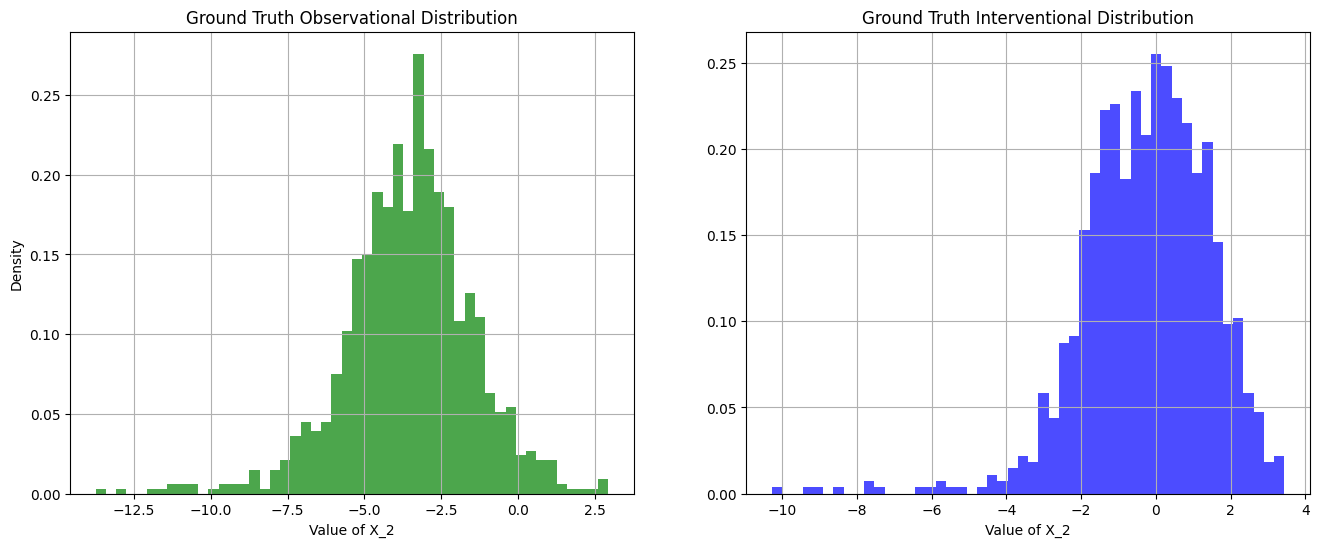


--- Quantitative Evaluation for: do(x_11=0.0) -> x_2 ---
Wasserstein Distance (SVGD vs. Ground Truth): 2.0547
Wasserstein Distance (Ensemble vs. Ground Truth): 2.1761


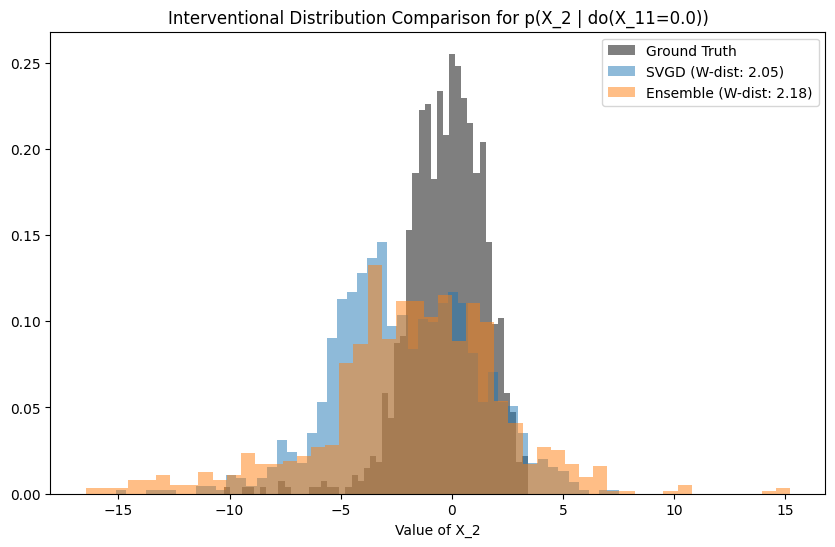

In [55]:
# dibs/examples/ensemble_experiments.ipynb

# --- Part 1: Find relevant interventions and rank their strength ---
# This new strategy is more targeted and efficient. Instead of checking every
# edge, we select a single target node and only assess interventions on its
# causal ancestors.

from scipy.stats import wasserstein_distance

# Parameters
n_assess_samples = 1000  # Samples to assess effect strength
n_interv_samples = 1000  # Samples for final histogram
interv_value = 0.0
n_top_links = 4 # Number of top links to analyze

# Convert to numpy for easier manipulation
import numpy as np
g_true_np = np.array(data.g)
theta_np = data.theta

# Create igraph for graph operations
g_true_igraph = ig.Graph.Adjacency(g_true_np.tolist())

# 1. Select a target node for observation (e.g., the last node in a topological sort)
topological_order = g_true_igraph.topological_sorting()
target_node_i = topological_order[-1]
print(f"Target node for observation selected: x_{target_node_i} (last in topological order)")

# 2. Find all ancestors of the target node. These are the only relevant candidates for intervention.
ancestors = g_true_igraph.subcomponent(target_node_i, mode='in')
candidate_interv_nodes_j = [node for node in ancestors if node != target_node_i]

if not candidate_interv_nodes_j:
    raise ValueError(f"Target node x_{target_node_i} has no ancestors to intervene on.")
print(f"Found {len(candidate_interv_nodes_j)} candidate intervention nodes for target x_{target_node_i}.")

# 3. Measure causal effect strength for each candidate ancestor on the target node.
#    This is the correct approach for nonlinear models where thetas are not direct weights.
effect_strengths = []
print("\nAssessing causal effect strength for each candidate intervention...")
# Get a single baseline observational sample to compare against all interventions.
key, subk = random.split(key)
obs_samples_for_baseline = generative_model.sample_obs(key=subk, n_samples=n_assess_samples, g=g_true_igraph, theta=theta_np, interv=None)
obs_mean_baseline = np.mean(obs_samples_for_baseline[:, target_node_i])

for j in candidate_interv_nodes_j:
    key, subk = random.split(key)
    interv_dict = {j: interv_value}
    interv_samples = generative_model.sample_obs(key=subk, n_samples=n_assess_samples, g=g_true_igraph, theta=theta_np, interv=interv_dict)
    interv_mean = np.mean(interv_samples[:, target_node_i])
    strength = abs(interv_mean - obs_mean_baseline)
    effect_strengths.append(strength)
    print(f"  do(x_{j}={interv_value}) -> x_{target_node_i}: strength = {strength:.4f}")

# 4. Select and store the top N strongest interventions (causal links).
sorted_indices = np.argsort(effect_strengths)[::-1]
top_n_indices = sorted_indices[:min(n_top_links, len(candidate_interv_nodes_j))]

print(f"\nSelected top {len(top_n_indices)} strongest causal links to target x_{target_node_i}:")
top_links = []
for idx in top_n_indices:
    j = candidate_interv_nodes_j[idx]
    strength = effect_strengths[idx]
    top_links.append({'parent': j, 'child': target_node_i, 'strength': strength})
    print(f"  Intervention: do(x_{j}), Observe: x_{target_node_i} (strength {strength:.4f})")

# --- Part 2: Visualize Ground Truth Distributions for the Strongest Link ---
# The 'top_links' variable now holds the most interesting interventions to analyze.
# We will proceed with the #1 strongest link for visualization.
strongest_link = top_links[0]
j = strongest_link['parent']
i = strongest_link['child'] # This is our target_node_i
interv_dict_strongest = {j: interv_value}

print(f"\nVisualizing Ground Truth for strongest link: p(X_{i}) vs. p(X_{i} | do(X_{j}={interv_value}))")
# Sample observational data
key, subk = random.split(key)
gt_obs_samples = generative_model.sample_obs(key=subk, n_samples=n_interv_samples, g=g_true_igraph, theta=theta_np, interv=None)

# Sample interventional data for the strongest link
key, subk = random.split(key)
gt_interv_samples_strongest = generative_model.sample_obs(key=subk, n_samples=n_interv_samples, g=g_true_igraph, theta=theta_np, interv=interv_dict_strongest)

# Plot histograms for comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.7, color='green', label=f'Observational p(X_{i})')
axs[0].set_title(f"Ground Truth Observational Distribution")
axs[0].set_xlabel(f"Value of X_{i}")
axs[0].set_ylabel("Density")
axs[0].grid(True)

axs[1].hist(gt_interv_samples_strongest[:, i], bins=50, density=True, alpha=0.7, color='blue', label=f'Interventional p(X_{i}|do(X_{j}={interv_value}))')
axs[1].set_title(f"Ground Truth Interventional Distribution")
axs[1].set_xlabel(f"Value of X_{i}")
axs[1].grid(True)
plt.show()


# --- Part 3: Quantitative Evaluation of Learned Models using Wasserstein Distance ---
# Now, for the strongest link, we sample from the learned models and compare them
# to the ground truth using the Wasserstein distance. A lower score is better.

# (This requires the `sample_posterior_predictive` function from previous steps)
print(f"\n--- Quantitative Evaluation for: do(x_{j}={interv_value}) -> x_{i} ---")

# dibs/examples/ensemble_experiments.ipynb

# --- Helper Function for Posterior Predictive Sampling ---
# This function is needed to correctly sample from the collection of particles
# that represent the learned posterior distributions from SVGD and Ensembles.

def sample_posterior_predictive(gs, thetas, likelihood_model,
                                                     interv_dict, n_samples_per_particle,
                                                     obs_node, key):
    """
    Samples from the posterior predictive distribution of a DiBS model.

    This function implements the correct Bayesian procedure: for each particle (a sample
    from the posterior over models), it generates data from that particle's model.
    The combined data represents a sample from the posterior predictive distribution.

    Args:
        gs (jnp.ndarray): Array of graph adjacency matrices for each particle.
        thetas (PyTree): PyTree of parameters for each particle.
        likelihood_model (DenseNonlinearGaussian): The likelihood model instance (used as a stateless function container).
        interv_dict (dict or None): The intervention to apply, e.g., {'parent': value}. None for observational.
        n_samples_per_particle (int): Number of samples to draw from each particle's model.
        obs_node (int): The index of the node whose distribution we want to observe.
        key (jax.random.PRNGKey): JAX random key.

    Returns:
        np.ndarray or None: A flat array of all collected samples for the observed node,
                            or None if sampling failed for all particles.
    """

    all_samples = []
    n_particles = gs.shape[0]

    if n_particles == 0:
        print("Warning: No particles provided to sample from.")
        return None

    for p in range(n_particles):
        try:
            # Get the specific graph and parameters for this particle
            g_matrix = np.array(gs[p])
            particle_theta = jax.tree_map(lambda x: x[p], thetas)

            # The model requires an igraph object for sampling
            g_igraph = ig.Graph.Adjacency(g_matrix.tolist())

            # Critical check: topological sort is only possible on a DAG
            if not g_igraph.is_dag():
                continue

            # Sample from this specific particle's model
            key, subk = random.split(key)
            samples = likelihood_model.sample_obs(
                key=subk,
                n_samples=n_samples_per_particle,
                g=g_igraph,
                theta=particle_theta,
                interv=interv_dict
            )

            # Collect the samples for the specific node we are observing
            all_samples.append(samples[:, obs_node])

        except Exception as e:
            # This can happen if a particle is malformed, just skip it
            continue

    if not all_samples:
        print("Warning: Sampling failed for all particles (perhaps none were valid DAGs).")
        return None

    # Combine samples from all valid particles into one large sample
    return np.concatenate(all_samples)

# Sample from SVGD posterior
svgd_interv_samples = sample_posterior_predictive(gs_svgd, thetas_svgd, likelihood_model, interv_dict_strongest, n_interv_samples // N_PARTICLES, i, key)

# Sample from Ensemble posterior
ensemble_interv_samples = sample_posterior_predictive(combined_gs, combined_thetas, likelihood_model, interv_dict_strongest, n_interv_samples // N_ENSEMBLE_RUNS, i, key)

# Compute Wasserstein distance if sampling was successful
if svgd_interv_samples is not None and ensemble_interv_samples is not None:
    gt_samples_flat = gt_interv_samples_strongest[:, i]
    w_dist_svgd = wasserstein_distance(gt_samples_flat, svgd_interv_samples)
    w_dist_ensemble = wasserstein_distance(gt_samples_flat, ensemble_interv_samples)

    print(f"Wasserstein Distance (SVGD vs. Ground Truth): {w_dist_svgd:.4f}")
    print(f"Wasserstein Distance (Ensemble vs. Ground Truth): {w_dist_ensemble:.4f}")

    # Optional: Visualize all three distributions
    plt.figure(figsize=(10, 6))
    plt.hist(gt_samples_flat, bins=50, density=True, label='Ground Truth', alpha=0.5, color='black')
    plt.hist(svgd_interv_samples, bins=50, density=True, label=f'SVGD (W-dist: {w_dist_svgd:.2f})', alpha=0.5)
    plt.hist(ensemble_interv_samples, bins=50, density=True, label=f'Ensemble (W-dist: {w_dist_ensemble:.2f})', alpha=0.5)
    plt.title(f"Interventional Distribution Comparison for p(X_{i} | do(X_{j}={interv_value}))")
    plt.xlabel(f"Value of X_{i}")
    plt.legend()
    plt.show()
else:
    print("\nSkipping quantitative evaluation due to sampling errors from learned models.")


# SAVING AND LOADING

In [52]:
# Save ground truth data and trained models
import pickle
import numpy as np
import jax
import time
import os
def save_experiment(data, gs_svgd, thetas_svgd, combined_gs, combined_thetas,
                   generative_model, likelihood_model, filename="dibs_experiment.pkl"):
    """Save complete experiment: ground truth + trained models."""

    experiment_data = {
        'ground_truth': {
            'g': np.array(data.g),
            'theta': jax.tree_map(lambda x: np.array(x), data.theta),
            'x': np.array(data.x),
            'x_ho': np.array(data.x_ho),
            'x_interv': [(interv_dict, np.array(x_interv)) for interv_dict, x_interv in data.x_interv]
        },
        'svgd_model': {
            'gs': np.array(gs_svgd),
            'thetas': jax.tree_map(lambda x: np.array(x), thetas_svgd),
            'n_particles': gs_svgd.shape[0]
        },
        'ensemble_model': {
            'gs': np.array(combined_gs),
            'thetas': jax.tree_map(lambda x: np.array(x), combined_thetas),
            'n_particles': combined_gs.shape[0]
        },
        'experiment_config': {
            'n_vars': data.g.shape[0],
            'n_observations': data.x.shape[0],
            'n_ho_observations': data.x_ho.shape[0],
            'svgd_particles': gs_svgd.shape[0],
            'ensemble_runs': combined_gs.shape[0],
            'model_type': 'DenseNonlinearGaussian',
            'hidden_layers': generative_model.hidden_layers,
            'obs_noise': generative_model.obs_noise,
            'sig_param': generative_model.sig_param,
            'save_timestamp': time.time()
        }
    }

    with open(filename, 'wb') as f:
        pickle.dump(experiment_data, f)

    print(f"✅ Experiment saved to {filename}")
    print(f"   - Ground truth: {data.g.shape[0]} variables")
    print(f"   - SVGD: {gs_svgd.shape[0]} particles")
    print(f"   - Ensemble: {combined_gs.shape[0]} particles")
    print(f"   - File size: {os.path.getsize(filename) / 1024 / 1024:.2f} MB")

# Save the experiment
#save_experiment(data, gs_svgd, thetas_svgd, combined_gs, combined_thetas,
#               generative_model, likelihood_model, "my_dibs_experiment.pkl")

In [53]:
# Load saved experiment
def load_experiment(filename="my_dibs_experiment.pkl"):
    """Load saved experiment data."""

    with open(filename, 'rb') as f:
        experiment_data = pickle.load(f)

    # Convert back to JAX arrays
    data_loaded = type('Data', (), {
        'g': jnp.array(experiment_data['ground_truth']['g']),
        'theta': jax.tree_map(lambda x: jnp.array(x), experiment_data['ground_truth']['theta']),
        'x': jnp.array(experiment_data['ground_truth']['x']),
        'x_ho': jnp.array(experiment_data['ground_truth']['x_ho']),
        'x_interv': [(interv_dict, jnp.array(x_interv)) for interv_dict, x_interv in experiment_data['ground_truth']['x_interv']]
    })()

    gs_svgd_loaded = jnp.array(experiment_data['svgd_model']['gs'])
    thetas_svgd_loaded = jax.tree_map(lambda x: jnp.array(x), experiment_data['svgd_model']['thetas'])

    combined_gs_loaded = jnp.array(experiment_data['ensemble_model']['gs'])
    combined_thetas_loaded = jax.tree_map(lambda x: jnp.array(x), experiment_data['ensemble_model']['thetas'])

    config = experiment_data['experiment_config']

    print(f"✅ Experiment loaded from {filename}")
    print(f"   - Saved on: {time.ctime(config['save_timestamp'])}")
    print(f"   - Variables: {config['n_vars']}")
    print(f"   - SVGD particles: {config['svgd_particles']}")
    print(f"   - Ensemble particles: {config['ensemble_runs']}")

    return data_loaded, gs_svgd_loaded, thetas_svgd_loaded, combined_gs_loaded, combined_thetas_loaded, config

# Usage:
# data, gs_svgd, thetas_svgd, combined_gs, combined_thetas, config = load_experiment("my_dibs_experiment.pkl")